In [8]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la

In [2]:
def txt_to_numpy(filename):
    a_file = open(filename)
    file_contents = a_file.read()
    contents_split = file_contents.splitlines()
    array=[]
    for i in range(len(contents_split)):
        array.append( np.array([x for x in contents_split[i].split(',')]))
    return np.array(array).astype(float)

In [3]:
#read in training dataset and labels
training_set=txt_to_numpy("handwriting_training_set.txt")
training_labels=txt_to_numpy("handwriting_training_set_labels.txt")
#read in test dataset and labels
test_set=txt_to_numpy("handwriting_test_set.txt")
test_labels=txt_to_numpy("handwriting_test_set_labels.txt")

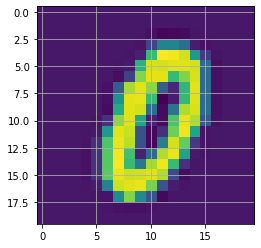

In [4]:

number=training_set[2]
number=np.reshape(number,(20,20)) 
plt.imshow(number.T, cmap=plt.get_cmap('viridis')) 
plt.grid();

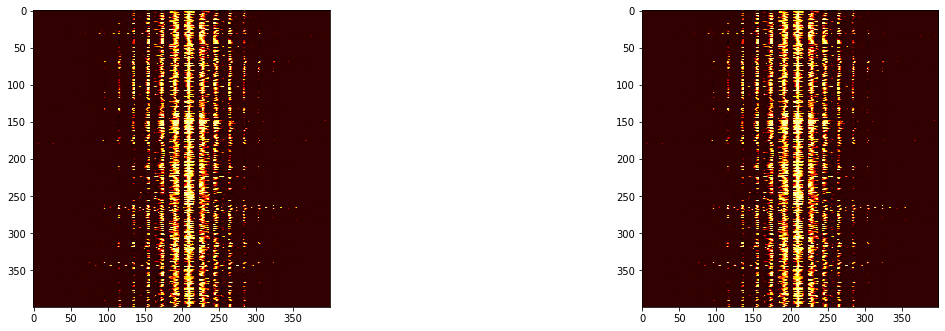

In [156]:
training_digits=np.split(training_set,10)
#initialize lists for storing the decompositions for each digit matrix
L_singular_vectors=[]
Sigma_matrices=[]
R_singular_vectors=[]

fig = plt.figure(figsize=(20, 12))
fig.add_subplot(2, 2, 1)
plt.imshow(training_digits[1], cmap='hot', interpolation='nearest')


#Compute the SVD for each digit and store the resulting matrices that form the decomposition in a new matrix 
for i in range(10):
    #compute svd for the digit  i 
    U,S,V = la.svd(training_digits[i],full_matrices=False)
    L_singular_vectors.append(U)
    Sigma_matrices.append(S)# use np.diag(S) for nxn matrix of singular values 
    R_singular_vectors.append(V)
    
    
#conver the lists to numpy arrays after storing all of the decompositions
Us=np.array(L_singular_vectors).astype(float)
Ss=np.array(Sigma_matrices).astype(float)
Vs=np.array(R_singular_vectors).astype(float)


fig.add_subplot(2, 2, 2)
plt.imshow(Us[1]*Ss[1]@Vs[1], cmap='hot', interpolation='nearest')

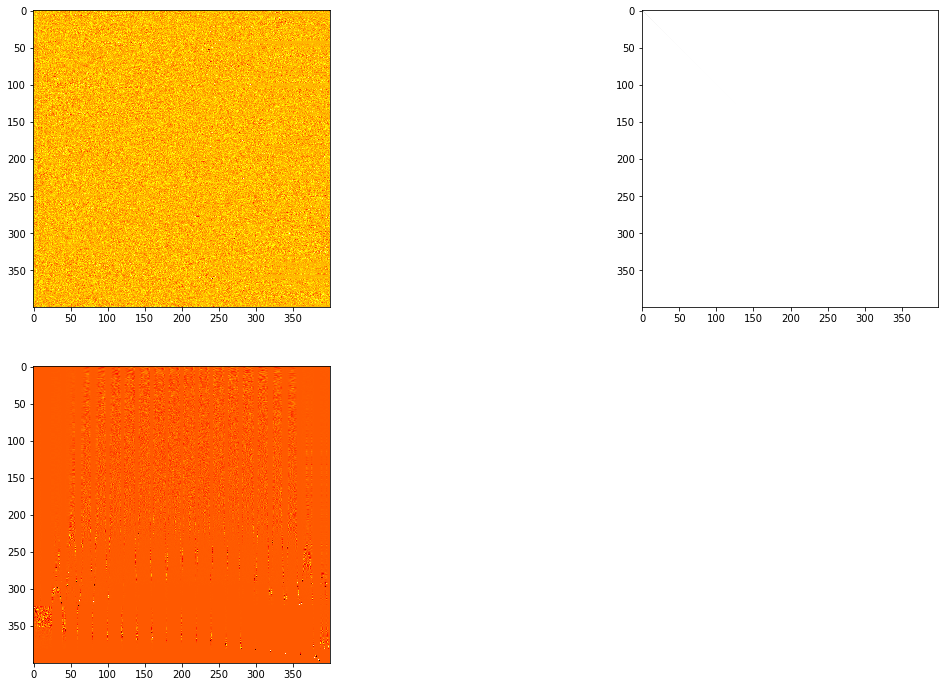

In [158]:
fig = plt.figure(figsize=(20, 12))
fig.add_subplot(2, 2, 1)
plt.imshow(Us[0], cmap='hot', interpolation='nearest',)
fig.add_subplot(2, 2, 2)
plt.imshow(np.diag(Ss[1]), cmap='Greys', interpolation='nearest')
fig.add_subplot(2, 2, 3)
plt.imshow(Vs[0], cmap='hot', interpolation='nearest')

Shape of U    : (10, 400, 400)
Shape of Sigma: (10, 400)
Shape of VT   : (10, 400, 400)


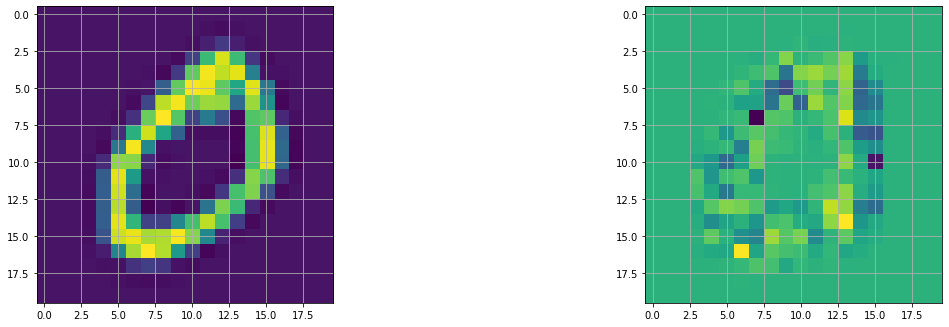

In [174]:
#This structure allows us to use nested indicies to reference parts of the various svds computed
# For instance the first unitary vector for digit 0 is Us[0][1] etc,
sample=0

#print SVD dimensions
print("Shape of U    :",np.shape(Us))
print("Shape of Sigma:",np.shape(Ss))
print("Shape of VT   :",np.shape(Vs))


control=np.reshape(training_set[sample],(20,20))

#PLOT test entry 
fig = plt.figure(figsize=(20, 12))
#plot
fig.add_subplot(2, 2, 1)
plt.imshow(control.T, cmap=plt.get_cmap('viridis')) 
plt.grid();

#compute svd reconstructed entry
data_test=Ss[0][sample]*Us[0][sample]*Vs[0][sample]
data_test=np.reshape(data_test,(20,20))

#PLOT
fig.add_subplot(2, 2, 2)
plt.grid();
plt.imshow(data_test.T, cmap=plt.get_cmap('viridis')) 





